# Market Research

First let's load data in:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

display(train_data.head())

,time,A,B,C,D,E,F,G,H,I,J,K,L,M,N,Y1,Y2
0,0,0.207366,-0.159951,-0.634176,-0.580962,-0.266505,0.060173,-0.475257,-1.486516,-0.332594,-0.671466,-0.226149,-0.187624,-0.780237,-0.785965,-0.935902,-0.310081
1,1,0.188828,-0.265508,0.042143,-0.550442,-0.132319,-0.185219,0.028295,0.093210,-0.518139,-0.251917,-0.347845,-0.359069,-0.161254,0.020401,-0.089707,-0.305374
2,2,-0.144261,-0.577142,-0.214634,-0.747391,-0.184255,-0.464831,-0.085181,0.700449,-0.603438,0.197773,-0.566696,-0.580799,0.202726,0.135261,-0.077855,-0.631485
3,3,0.208982,-0.310449,0.513708,-0.562868,0.742308,-0.305487,0.762246,1.363020,-0.384575,0.525556,-0.348514,-0.428099,0.548993,0.471031,0.941271,-0.535212
4,4,0.093320,-0.358156,0.173188,-0.687296,-0.161461,-0.116062,-0.245748,0.863372,-0.655588,-0.263358,-0.557428,-0.481214,0.083602,0.003087,-0.039582,-0.490561


We want a function to score the features A-N in relation to Y1 and Y2, later, we'll also investigate relationships between features;

In [2]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

X = train_data.drop(["time", "Y1", "Y2"], axis = 1)

y = train_data["Y1"]

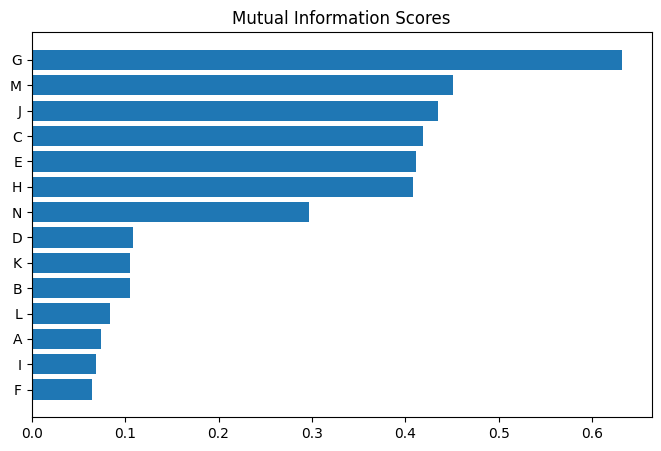

In [3]:
mi_scores = make_mi_scores(X, y)

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

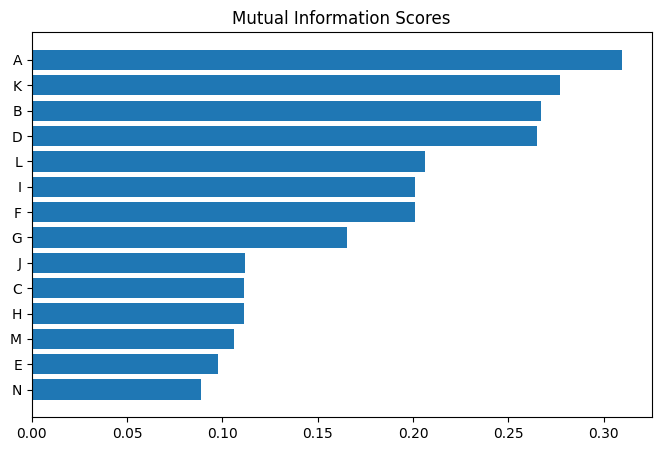

In [4]:
y = train_data["Y2"]
mi_scores = make_mi_scores(X, y)

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

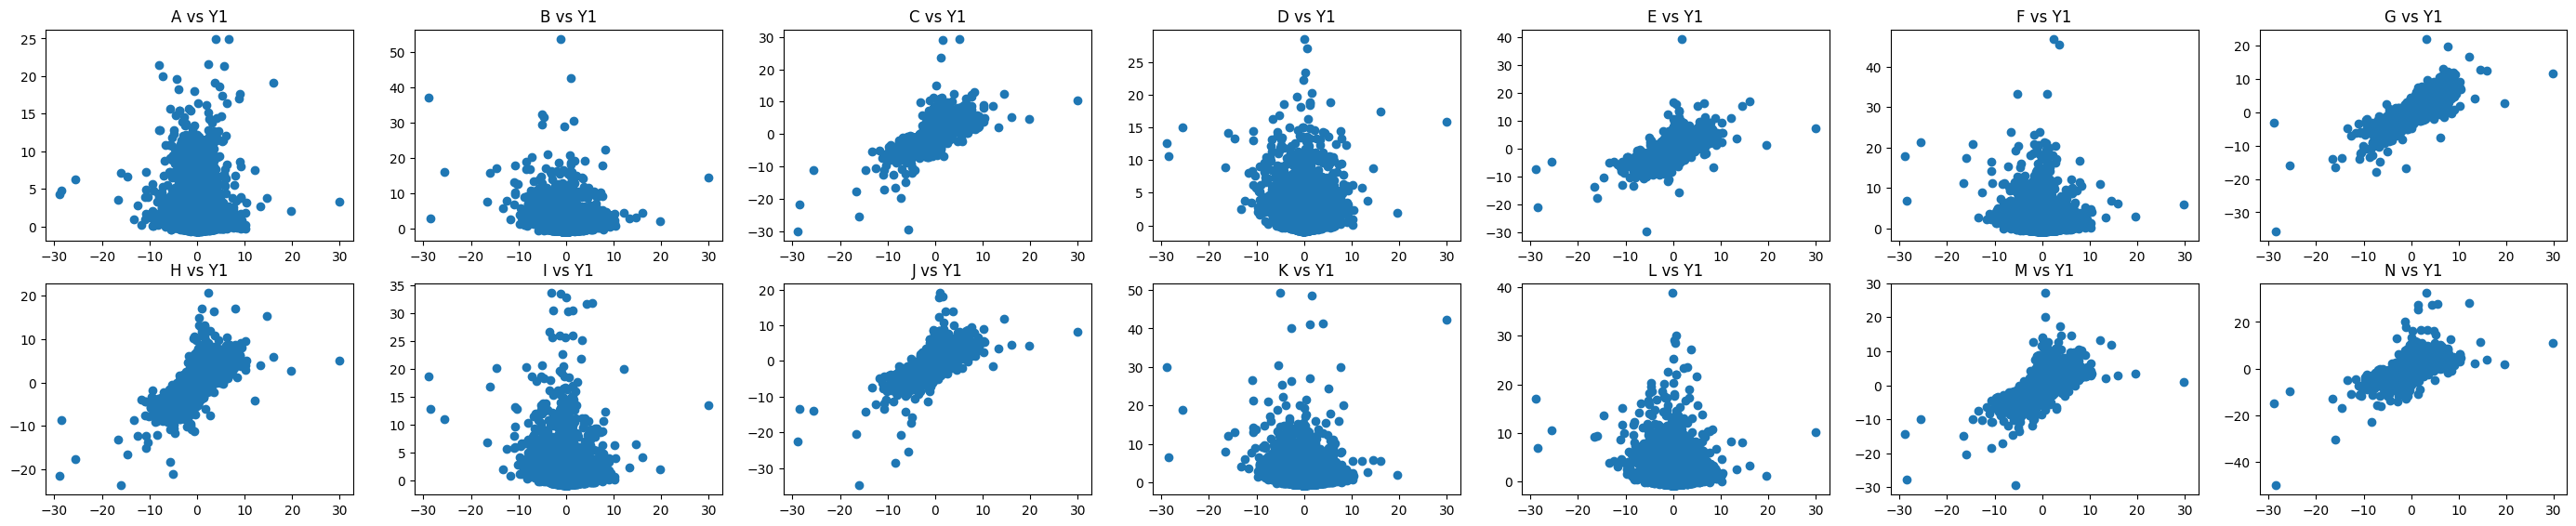

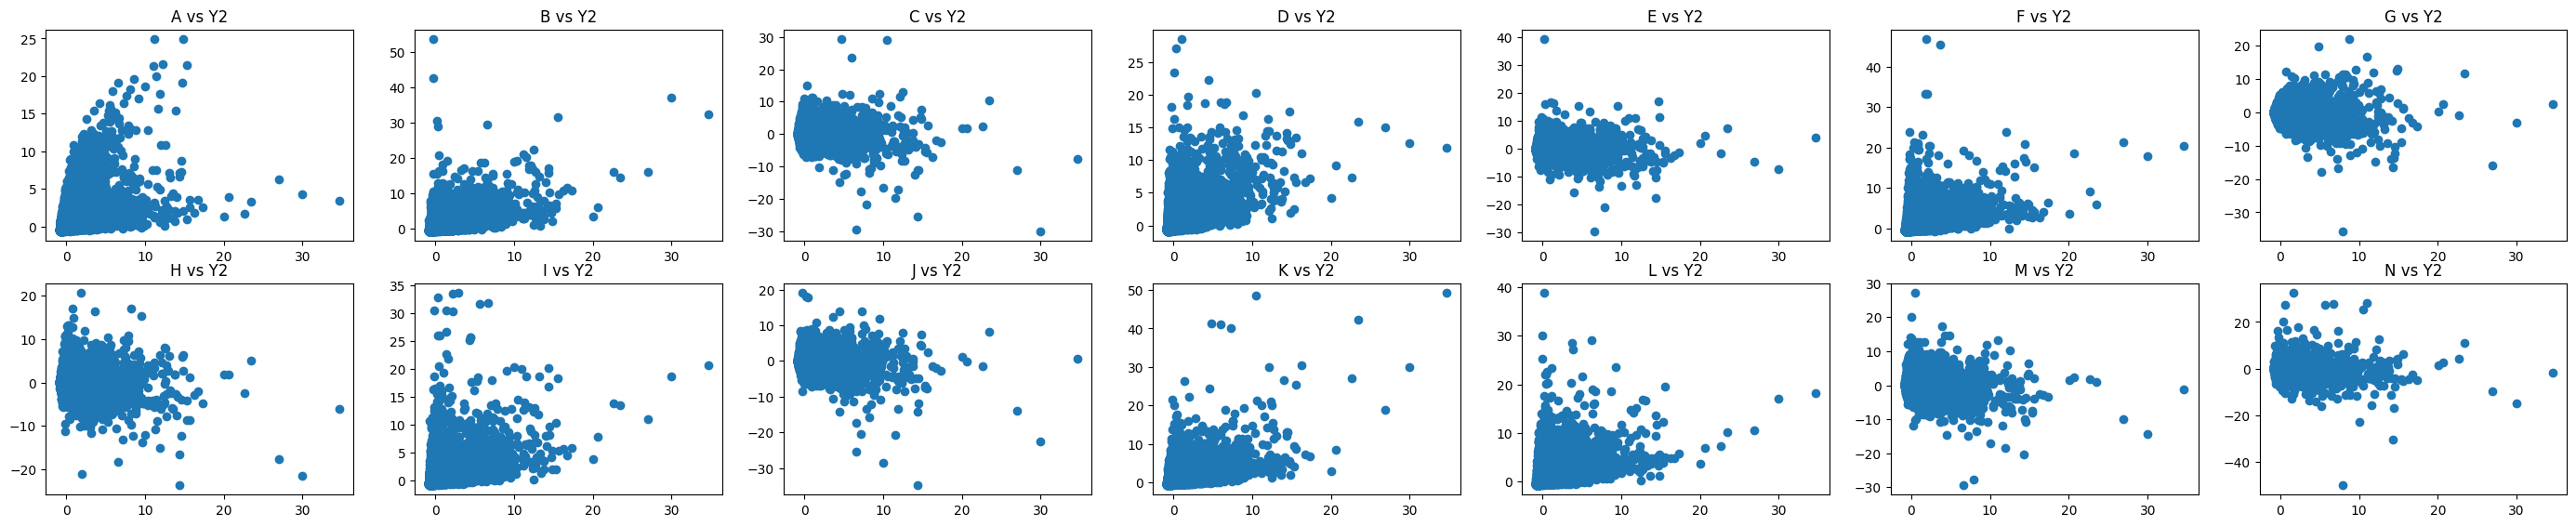

In [5]:
def plot_rels(features, target, nrows = 2, ncols = 7):
    fig, axs = plt.subplots(nrows = nrows, ncols = ncols, sharex=False, sharey=False, squeeze=False, figsize = [ncols * 5, nrows * 3 + 0.5])

    for i in range(nrows):
        for j in range(ncols):
            axs[i,j].scatter(train_data[target], (train_data[features[i][j]].values), )
            axs[i,j].set_title(f"{features[i][j]} vs {target}")

    return fig

features = ["A", "B", "C", "D", "E", "F", "G"], ["H", "I", "J", "K", "L", "M", "N"]

plot_rels(features, "Y1")

plot_rels(features, "Y2")

plt.show()

Okay, we have some linear relationships in Y1, but Y2 is a lot more complicated, we want to run PCA to analyse underlying;

In [6]:
from sklearn.decomposition import PCA

A = train_data.drop(["time", "Y1", "Y2"], axis=1)

A = (A - A.mean(axis=0)) / A.std(axis=0)

pca = PCA(n_components= 3)

A_pca = pca.fit_transform(A)

train_data["PC1"] = A_pca[:,0]
train_data["PC2"] = A_pca[:,1]
train_data["PC3"] = A_pca[:,2]


print(pca.explained_variance_ratio_)

A_pca[:,0] = -A_pca[:,0]

[0.35230098 0.24448753 0.06840539]


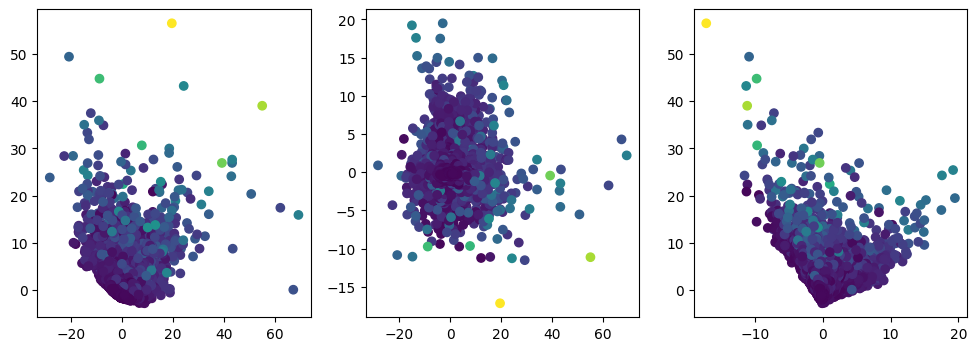

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = [12, 4])

ax1.scatter(A_pca[:,0], A_pca[:,1], c=train_data["Y2"], cmap="viridis")
ax2.scatter(A_pca[:,0], A_pca[:,2], c=train_data["Y2"], cmap="viridis")
ax3.scatter(A_pca[:,2], A_pca[:,1], c=train_data["Y2"], cmap="viridis")

plt.show()

In [8]:
pcs = pd.DataFrame(A_pca, columns=["PC1", "PC2", "PC3"])

mi_scores = make_mi_scores(pcs, train_data["Y2"])

print(mi_scores)

PC2    0.302615
PC1    0.157275
PC3    0.147997
Name: MI Scores, dtype: float64


In [9]:
features = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N"]

loadings = pd.DataFrame(
    pca.components_.T,
    columns = ["PC1", "PC2", "PC3"],
    index = features
)

display(loadings)

,PC1,PC2,PC3
A,-0.049503,0.228172,0.836061
B,-0.121040,0.399984,-0.194049
C,0.380406,0.112226,-0.025409
D,-0.098307,0.387751,0.313322
E,0.355846,0.117318,0.053069
F,-0.102438,0.333231,0.071754
G,0.369099,0.108326,0.021539
H,0.358870,0.088985,0.027080
I,-0.111260,0.387126,-0.159997
J,0.383499,0.094016,-0.014250


In [10]:
display(train_data)

,time,A,B,C,D,E,F,G,H,I,J,K,L,M,N,Y1,Y2,PC1,PC2,PC3
0,0,0.207366,-0.159951,-0.634176,-0.580962,-0.266505,0.060173,-0.475257,-1.486516,-0.332594,-0.671466,-0.226149,-0.187624,-0.780237,-0.785965,-0.935902,-0.310081,-1.645706,-1.049790,0.158901
1,1,0.188828,-0.265508,0.042143,-0.550442,-0.132319,-0.185219,0.028295,0.093210,-0.518139,-0.251917,-0.347845,-0.359069,-0.161254,0.020401,-0.089707,-0.305374,0.106068,-0.886300,0.217030
2,2,-0.144261,-0.577142,-0.214634,-0.747391,-0.184255,-0.464831,-0.085181,0.700449,-0.603438,0.197773,-0.566696,-0.580799,0.202726,0.135261,-0.077855,-0.631485,0.649277,-1.341526,0.044834
3,3,0.208982,-0.310449,0.513708,-0.562868,0.742308,-0.305487,0.762246,1.363020,-0.384575,0.525556,-0.348514,-0.428099,0.548993,0.471031,0.941271,-0.535212,1.988952,-0.401970,0.238411
4,4,0.093320,-0.358156,0.173188,-0.687296,-0.161461,-0.116062,-0.245748,0.863372,-0.655588,-0.263358,-0.557428,-0.481214,0.083602,0.003087,-0.039582,-0.490561,0.461081,-1.079215,0.222449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,80000,-0.339802,-0.372094,-0.120952,-0.363438,0.266299,-0.222866,-0.000358,0.470755,-0.412086,-0.332426,-0.374358,-0.251086,-0.058820,0.312828,-0.564065,-0.154864,0.407394,-0.830936,-0.141211
79996,80001,-0.421921,-0.222554,-0.689585,-0.512266,-0.206562,-0.494450,-0.197705,-0.566908,-0.570731,-1.093729,-0.382964,-0.249580,-0.446410,-0.527049,0.031323,-0.474736,-1.054781,-1.401283,-0.236306
79997,80002,-0.467038,-0.282018,0.010707,-0.589594,0.067635,-0.410820,0.032695,-0.506164,-0.513340,-0.871582,-0.345584,-0.402364,-0.372984,-0.419894,-0.213572,-0.503083,-0.435297,-1.278273,-0.267698
79998,80003,-0.369710,-0.322384,-0.540326,-0.563206,-0.568736,-0.550024,-0.339077,-0.903734,-0.212600,-0.571418,-0.223712,-0.307187,-1.057527,-2.012514,-0.600713,-0.233209,-1.825927,-1.506428,-0.204131


Let's attempt an initial implementation of a model

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X = train_data[["G", "M", "J", "C", "E", "H", "N"]]

y = train_data["Y1"]

X_train, X_val, y1_train, y1_val = train_test_split(X, y)

modelY1 = RandomForestRegressor(n_estimators=200)

modelY1.fit(X_train, y1_train)

y1_pred = modelY1.predict(X_val)

X = train_data[["PC1" ,"PC2", "PC3"]]

y = train_data["Y2"]

X_train, X_val, y2_train, y2_val = train_test_split(X, y)

modelY2 = RandomForestRegressor(n_estimators=200)

modelY2.fit(X_train, y2_train)

y2_pred = modelY2.predict(X_val)

print(f"Predicted score : {(r2_score(y2_pred, y2_val) + r2_score(y1_pred, y1_val))/2}")
print(f"Score Y1 : {r2_score(y1_pred, y1_val)} \nScore Y2 : {r2_score(y2_pred, y2_val)}")

Predicted score : 0.5365630605168532
Score Y1 : 0.6533197228112726 
Score Y2 : 0.4198063982224337


Creating an output CSV file

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X1 = train_data[["G", "M", "J", "C", "E", "H", "N"]]

y1 = train_data["Y1"]

modelY1 = RandomForestRegressor(n_estimators=200)

modelY1.fit(X1, y1)

X2 = train_data[["PC1" ,"PC2", "PC3"]]

y2 = train_data["Y2"]

modelY2 = RandomForestRegressor(n_estimators=200)

modelY2.fit(X2, y2)

,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [13]:
X = train_data[["G", "M", "J", "C", "E", "H", "N"]]

y = train_data["Y1"]

X_train, X_val, y1_train, y1_val = train_test_split(X, y)

y1_pred = modelY1.predict(X_val)

X = train_data[["PC1" ,"PC2", "PC3"]]

y = train_data["Y2"]

X_train, X_val, y2_train, y2_val = train_test_split(X, y)

y2_pred = modelY2.predict(X_val)

print(f"Predicted score : {(r2_score(y2_pred, y2_val) + r2_score(y1_pred, y1_val))/2}")

Predicted score : 0.9477164650675436


In [14]:
from sklearn.decomposition import PCA

A = test_data.drop(["time"], axis=1)

A = (A - A.mean(axis=0)) / A.std(axis=0)

pca = PCA(n_components= 3)

A_pca = pca.fit_transform(A)

test_data["PC1"] = A_pca[:,0]
test_data["PC2"] = A_pca[:,1]
test_data["PC3"] = A_pca[:,2]

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X = test_data[["G", "M", "J", "C", "E", "H", "N"]]

y1_pred = pd.DataFrame(modelY1.predict(X), index = test_data.id, columns = ["Y1"])

X = test_data[["PC1" ,"PC2", "PC3"]]

y2_pred = pd.DataFrame(modelY2.predict(X), index = test_data.id, columns = ["Y2"])

out = pd.concat((y1_pred, y2_pred), axis = 1)

out.to_csv("./data/predictions.csv") # Scores 0.5888

This score isn't great, and I suspect that Y2 predictions are pulling the score down considerably - we need a better way to analyse Y2.

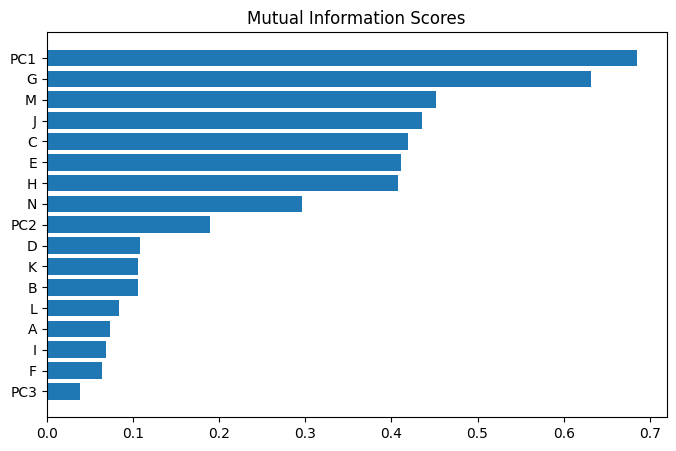

In [18]:
mi_scores = make_mi_scores(train_data.drop(["time", "Y1", "Y2"], axis = 1).dropna(axis = 0), train_data["Y1"])

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

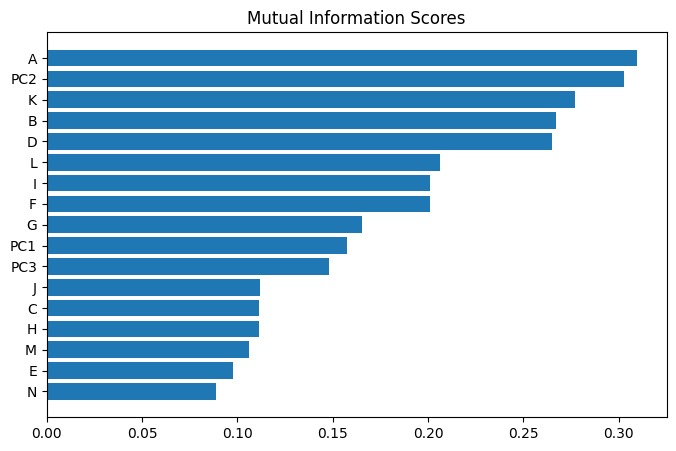

In [19]:
mi_scores = make_mi_scores(train_data.drop(["time", "Y1", "Y2"], axis = 1).dropna(axis = 0), train_data["Y2"])

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X = train_data[["G", "M", "J", "C", "E", "H", "N", "PC1"]]

y = train_data["Y1"]

X_train, X_val, y1_train, y1_val = train_test_split(X, y)

modelY1 = RandomForestRegressor(n_estimators=200)

modelY1.fit(X_train, y1_train)

y1_pred = modelY1.predict(X_val)

X = train_data[["PC2", "A", "K", "B", "D"]]

y = train_data["Y2"]

X_train, X_val, y2_train, y2_val = train_test_split(X, y)

modelY2 = RandomForestRegressor(n_estimators=200)

modelY2.fit(X_train, y2_train)

y2_pred = modelY2.predict(X_val)

print(f"Predicted score : {(r2_score(y2_pred, y2_val) + r2_score(y1_pred, y1_val))/2}")
print(f"Score Y1 : {r2_score(y1_pred, y1_val)} \nScore Y2 : {r2_score(y2_pred, y2_val)}")

# 0.61

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X1 = train_data[["G", "M", "J", "C", "E", "H", "N", "PC1"]]

y1 = train_data["Y1"]

modelY1 = RandomForestRegressor(n_estimators=200)

modelY1.fit(X1, y1)

X2 = train_data[["PC2", "A", "K", "B", "D"]]

y2 = train_data["Y2"]

modelY2 = RandomForestRegressor(n_estimators=200)

modelY2.fit(X2, y2)

In [ ]:
from sklearn.decomposition import PCA

A = test_data.drop(["time"], axis=1)

A = (A - A.mean(axis=0)) / A.std(axis=0)

pca = PCA(n_components= 3)

A_pca = pca.fit_transform(A)

test_data["PC1"] = A_pca[:,0]
test_data["PC2"] = A_pca[:,1]
test_data["PC3"] = A_pca[:,2]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X = test_data[["G", "M", "J", "C", "E", "H", "N", "PC1"]]

y1_pred = pd.DataFrame(modelY1.predict(X), index = test_data.id, columns = ["Y1"])

X = test_data[["PC2", "A", "K", "B", "D"]]

y2_pred = pd.DataFrame(modelY2.predict(X), index = test_data.id, columns = ["Y2"])

out = pd.concat((y1_pred, y2_pred), axis = 1)

out.to_csv("./data/predictions.csv")

- Better Y1 Estimator
- Better Y2 Features
- Outlier removal generally

- Lagging
- Any other time series stuff

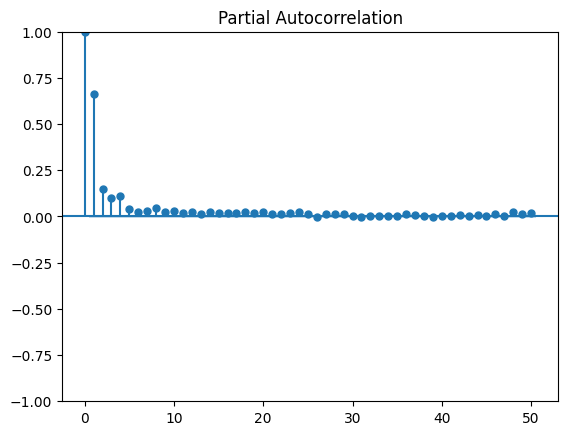

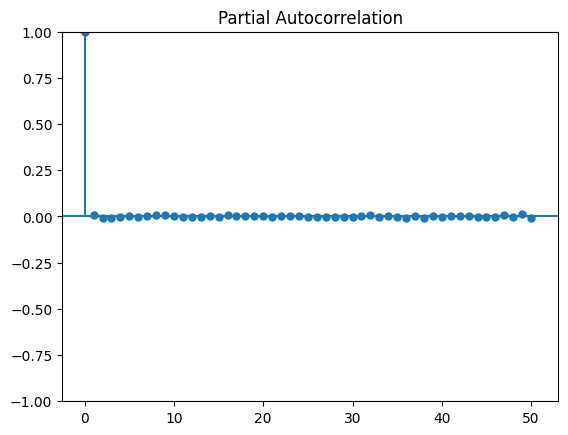

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(train_data["Y2"])
plot_pacf(train_data["Y1"])

plt.show()